In [1]:
import tensorflow
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras import Input
from tensorflow.keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import time
import os
import pydot
import graphviz
from keras.utils.vis_utils import plot_model

In [11]:
def shapepreprocessing(datapath,imgpath):
    df = pd.read_csv(datapath)
    Xpaths = df.iloc[0:1000,0:1]
    Y = df.iloc[0:1000,1:2]
    encoder = OneHotEncoder(sparse=False)
    Y = encoder.fit_transform(Y)
    X = []

    k = 0
    for path in Xpaths['Files']:
        img = cv2.imread(imgpath + path)/255.0
        img = cv2.resize(img,(60,40))
        X.append(img)
        if k % 5000==0:
            print(k)
        k+=1
    X = np.asarray(X)
    X = X.reshape( len(X), 40, 60, 3)
    return X,Y

def centerpreprocessing(datapath,imgpath):
    df = pd.read_csv(datapath)
    Xpaths = df.iloc[0:50000,0:1]
    tuples = df.iloc[0:50000,2:3]

    Y = np.empty((50000,2))
    for i in range(0, len(tuples)):
        val = tuples['Centers'][i].split(',')
        row = np.empty(2)
        row[0] = int(val[0][1:])/600
        row[1] = int(val[1][1:-1])/400
        Y[i] = row

    X = []
    k = 0
    for path in Xpaths['Files']:
        img = cv2.imread(imgpath + path)/255.0
        img = cv2.resize(img,(60,40))
        X.append(img)
        if k%5000==0:
            print(k)
        k+=1

    X = np.asarray(X)
    X = X.reshape( len(X), 40, 60, 3)
    return X,Y

def build_lionnet(inputs):
    branch1 = MaxPooling2D(pool_size=(3,3),strides=1,padding="same")(inputs)
    branch1 = Conv2D(filters=32,kernel_size=(1,1),strides=1, activation="relu")(branch1)
    
    branch2 = Conv2D(filters=16,kernel_size=(1,1),strides=1, activation="relu")(inputs)
    branch2 = Conv2D(filters=16,kernel_size=(1,1),strides=1, activation="relu")(branch2)
    
    branch3 = Conv2D(filters=64,kernel_size=(1,1),strides=1, activation="relu")(inputs)
    
    branch4 = Conv2D(filters=10,kernel_size=(1,1),strides=1, activation="relu")(inputs)
    branch4 = Conv2D(filters=16,kernel_size=(3,3),padding="same",strides=1, activation="relu")(branch4)
    branch4 = Conv2D(filters=24,kernel_size=(3,3),padding="same",strides=1, activation="relu")(branch4)
    
    branch5 = Conv2D(filters=10,kernel_size=(1,1),strides=1, activation="relu")(inputs)
    branch5 = Conv2D(filters=32,kernel_size=(5,5),padding="same",strides=1, activation="relu")(branch5)
    return Concatenate(axis=-1)([branch1,branch2,branch3,branch4,branch5])

def skip_connection(inputs):
    shape = inputs.shape
    skip = Conv2D(filters=shape[-1],kernel_size=(1,1),strides=1, activation="relu")(inputs)
    outputs = Conv2D(filters=64,kernel_size=(1,1),strides=1, activation="relu")(inputs)
    outputs = Conv2D(filters=64,kernel_size=(3,3),padding="same",strides=1, activation="relu")(outputs)
    outputs = Conv2D(filters=shape[-1],kernel_size=(1,1),strides=1, activation="relu")(outputs)
    return Add()([skip,outputs])

# Shape

In [12]:
X,Y = shapepreprocessing("./UAFSImageData/data.csv","./UAFSImageData/")
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)

0


In [13]:
inputs = Input(shape=(40,60,3))

outputs = Conv2D(filters=32,kernel_size=(5,5),strides=2,activation="relu")

outputs = skip_connection(inputs)
outputs = MaxPooling2D(pool_size=(2,2),strides=2)(outputs)

outputs = build_lionnet(outputs)
outputs = build_lionnet(outputs)

outputs = skip_connection(outputs)
outputs = MaxPooling2D(pool_size=(2,2),strides=2)(outputs)

outputs = Flatten()(outputs)
outputs = Dense(64, activation="relu")(outputs)
outputs = Dense(3, activation="linear")(outputs)

model = Model(inputs = inputs, outputs = outputs, name="lionnet")

Model: "lionnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40, 60, 3)]  0           []                               
                                                                                                  
 conv2d_56 (Conv2D)             (None, 40, 60, 64)   256         ['input_3[0][0]']                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 40, 60, 64)   36928       ['conv2d_56[0][0]']              
                                                                                                  
 conv2d_55 (Conv2D)             (None, 40, 60, 3)    12          ['input_3[0][0]']                
                                                                                            

 )                                                                                                
                                                                                                  
 flatten_2 (Flatten)            (None, 25200)        0           ['max_pooling2d_11[0][0]']       
                                                                                                  
 dense_4 (Dense)                (None, 64)           1612864     ['flatten_2[0][0]']              
                                                                                                  
 dense_5 (Dense)                (None, 3)            195         ['dense_4[0][0]']                
                                                                                                  
Total params: 1,786,822
Trainable params: 1,786,822
Non-trainable params: 0
__________________________________________________________________________________________________


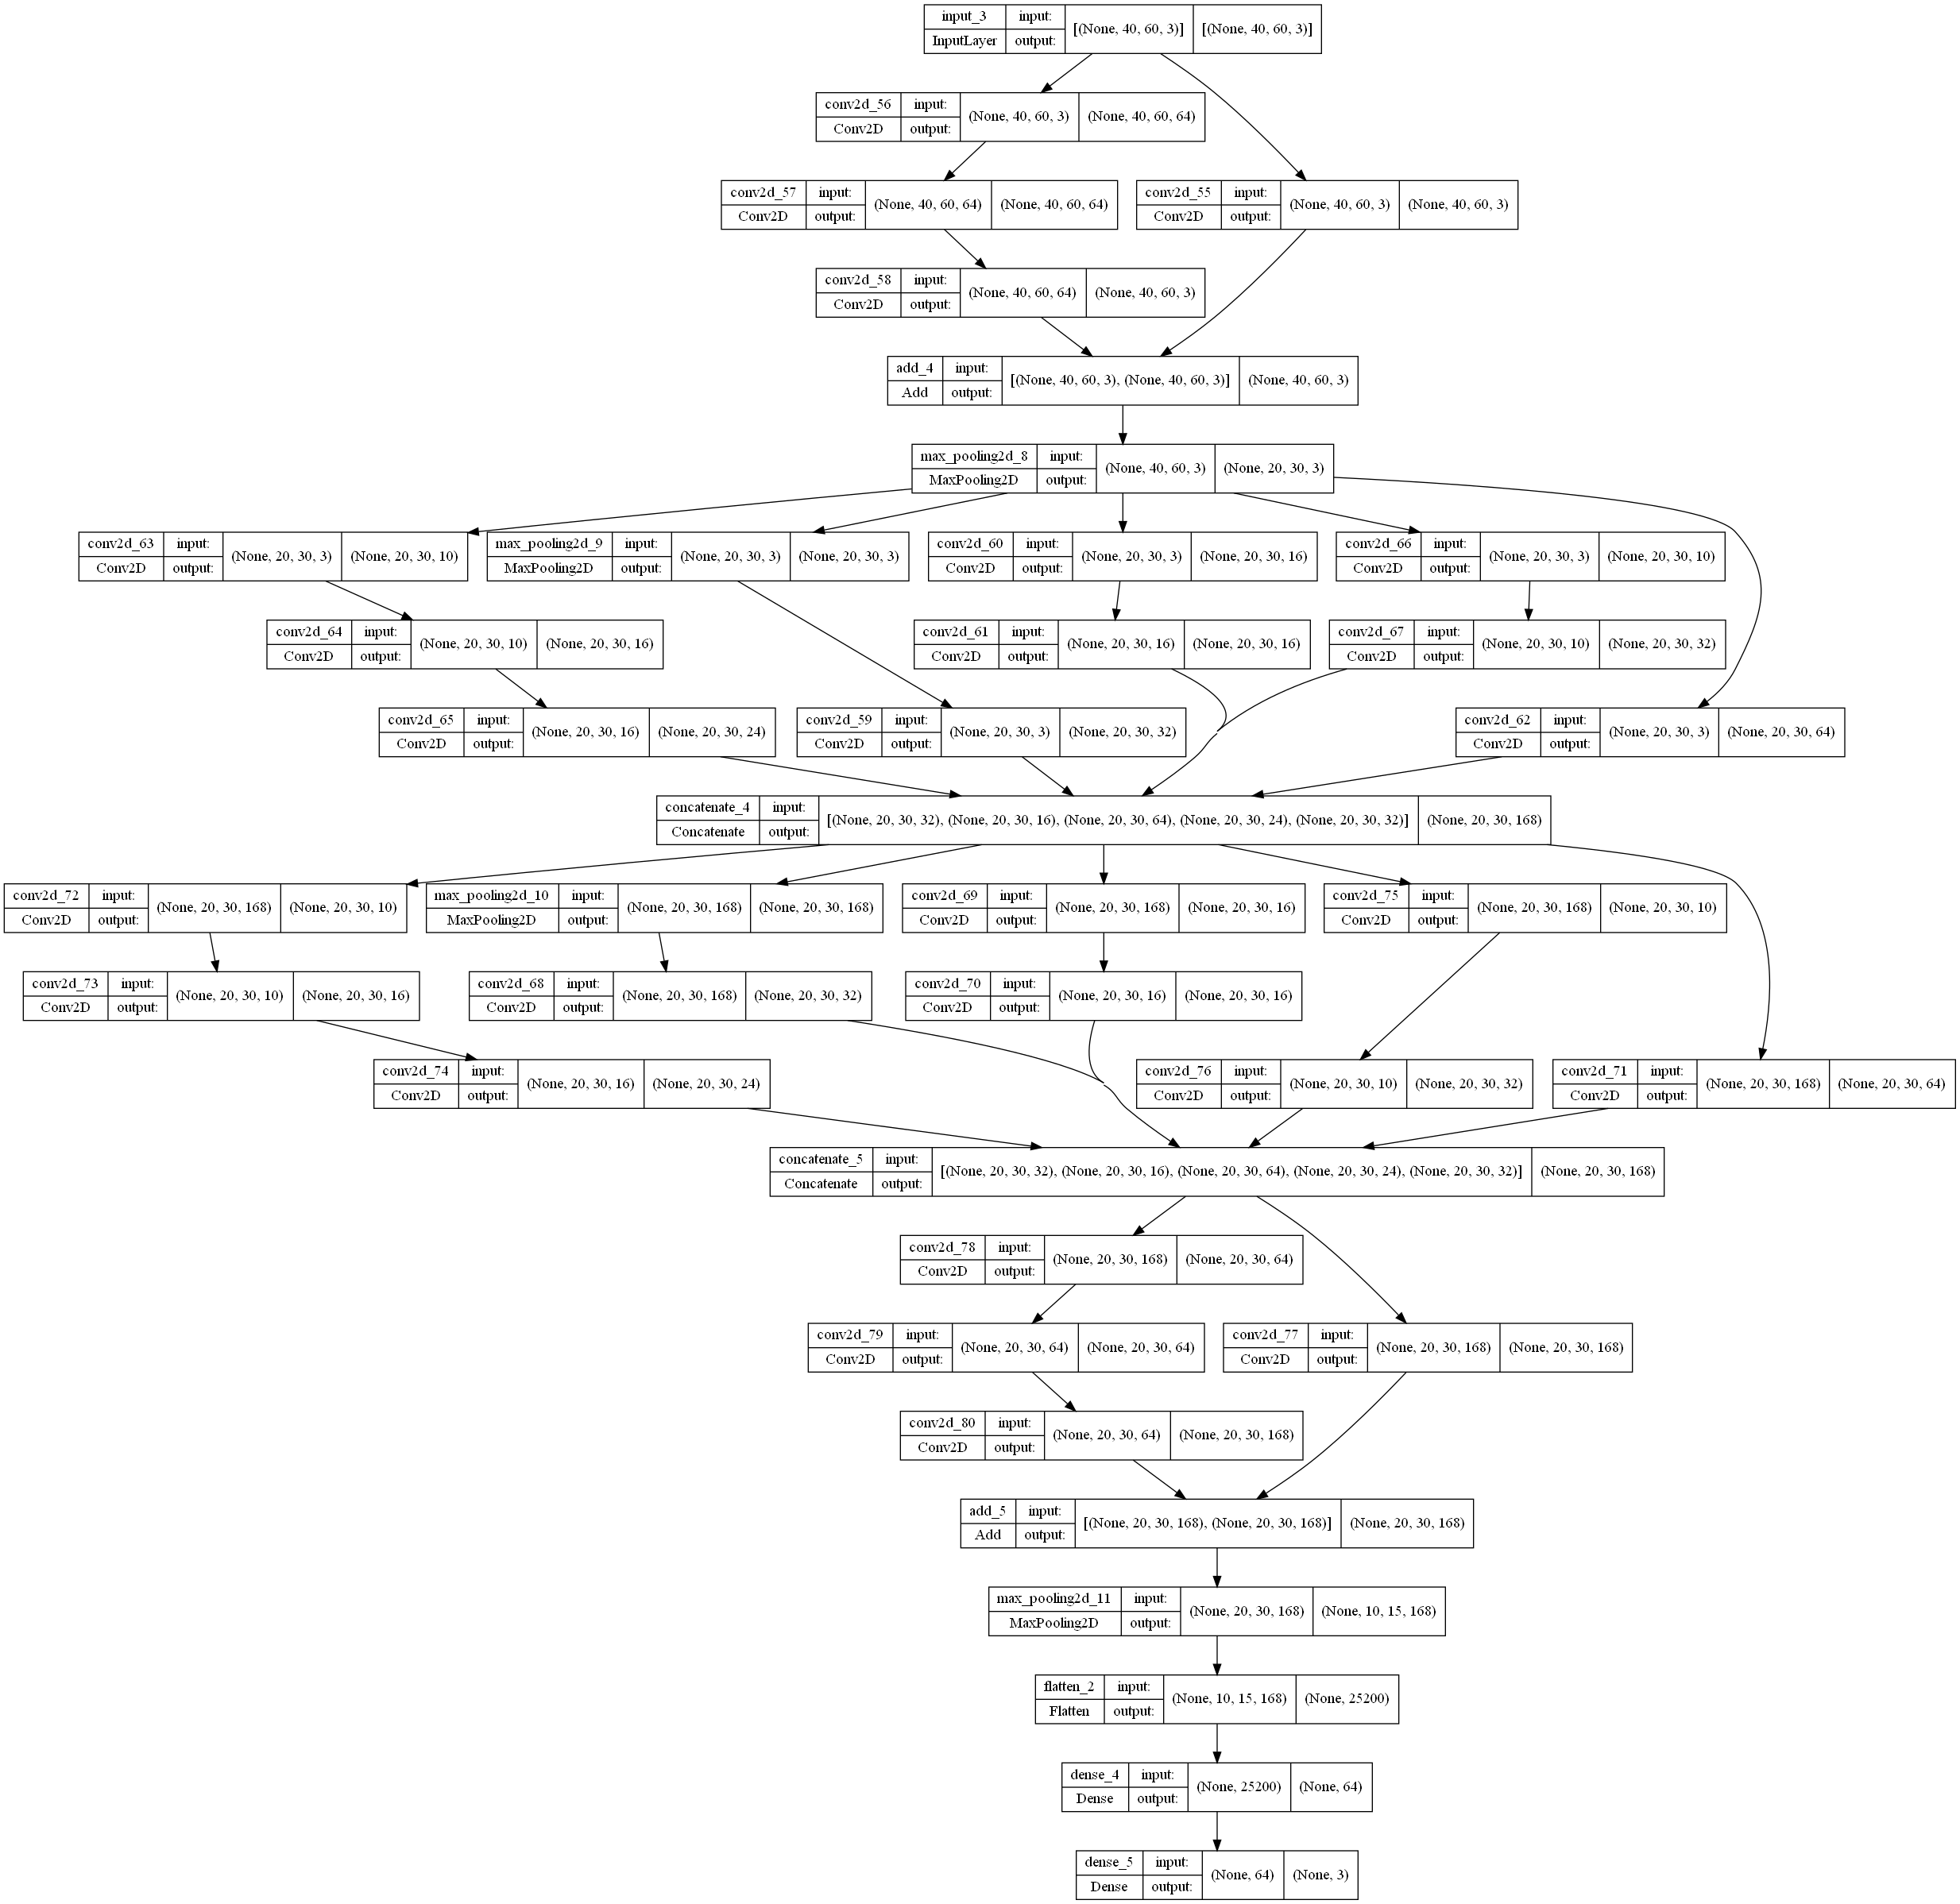

In [14]:
model.summary()
plot_model(model, to_file='mymodel.png', show_shapes=True, show_layer_names=True)

In [15]:
model.compile( optimizer="adam" , loss="mse", metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=2, batch_size=128, validation_split=0.1)

Epoch 1/2


In [ ]:
model.evaluate(x_test,y_test)

In [ ]:
labels = ['circle','rectangle','triangle']

In [ ]:
for i in range(16):
    img = x_test[i]
    input_image = np.array(img)
    input_image = input_image.reshape(1,40,60,3)
    prediction = model.predict(input_image)
    argmax = np.argmax(prediction)
    print(labels[argmax])
    plt.subplot(4, 4, i+1)
    plt.imshow(img, cmap="gray")

# Centerpoint

In [90]:
X,Y = centerpreprocessing("./UAFSImageData/data.csv","./UAFSImageData/")
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000


In [91]:
inputs = Input(shape=(40,60,3))

outputs = Conv2D(filters=64,kernel_size=(5,5),strides=2,activation="relu")

outputs = skip_connection(inputs)
outputs = MaxPooling2D(pool_size=(2,2),strides=2)(outputs)

outputs = build_lionnet(outputs)
outputs = build_lionnet(outputs)

outputs = skip_connection(outputs)
outputs = MaxPooling2D(pool_size=(2,2),strides=2)(outputs)

outputs = Flatten()(outputs)
outputs = Dense(64, activation="relu")(outputs)
outputs = Dense(2, activation="linear")(outputs)

model = Model(inputs = inputs, outputs = outputs, name="lionnet")

Model: "lionnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 40, 60, 3)]  0           []                               
                                                                                                  
 conv2d_313 (Conv2D)            (None, 40, 60, 64)   256         ['input_28[0][0]']               
                                                                                                  
 conv2d_314 (Conv2D)            (None, 40, 60, 64)   36928       ['conv2d_313[0][0]']             
                                                                                                  
 conv2d_312 (Conv2D)            (None, 40, 60, 3)    12          ['input_28[0][0]']               
                                                                                            

                                                                                                  
 max_pooling2d_49 (MaxPooling2D  (None, 10, 15, 168)  0          ['add_21[0][0]']                 
 )                                                                                                
                                                                                                  
 flatten_11 (Flatten)           (None, 25200)        0           ['max_pooling2d_49[0][0]']       
                                                                                                  
 dense_22 (Dense)               (None, 64)           1612864     ['flatten_11[0][0]']             
                                                                                                  
 dense_23 (Dense)               (None, 2)            130         ['dense_22[0][0]']               
                                                                                                  
Total para

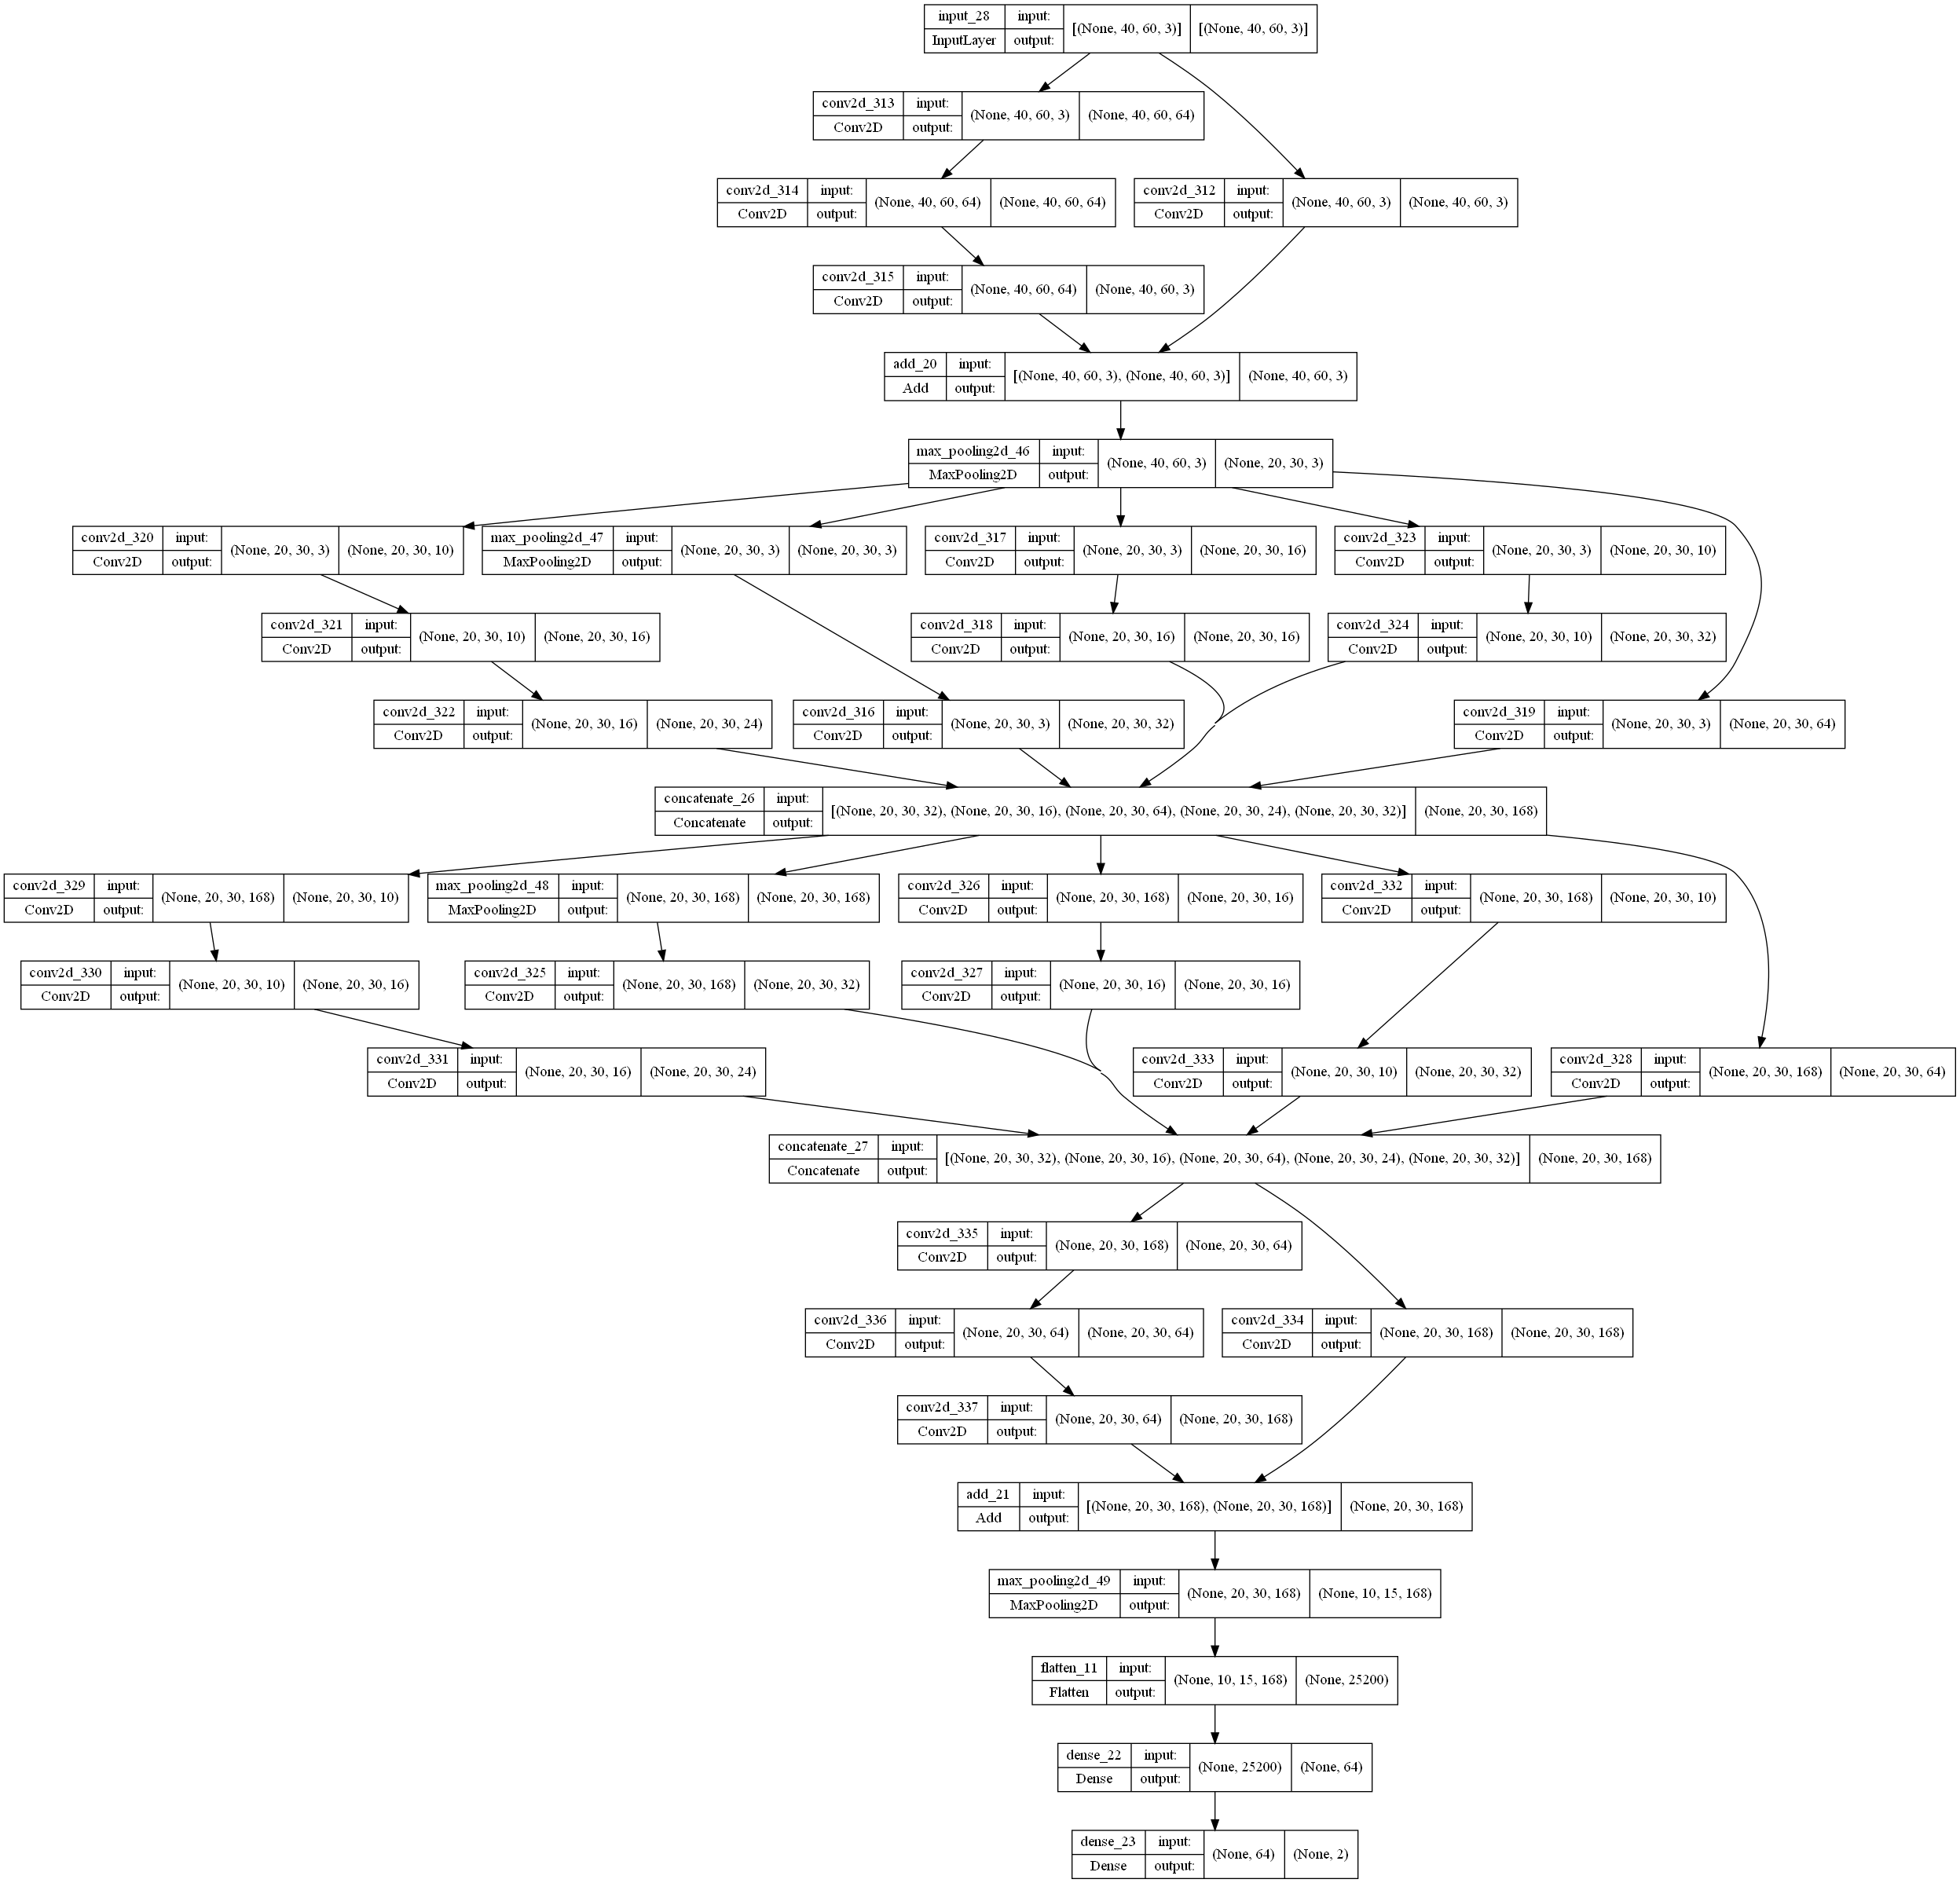

In [92]:
model.summary()
plot_model(model, to_file='mymodel.png', show_shapes=True, show_layer_names=True)

In [93]:
model.compile( optimizer="adam" , loss="mse", metrics=['accuracy'])

In [94]:
model.fit(x_train, y_train, epochs=2, batch_size=128, validation_split=0.1)

Epoch 1/2
282/282 [==============================] - 374s 1s/step - loss: 0.0785 - accuracy: 0.7088 - val_loss: 0.0039 - val_accuracy: 0.9330
Epoch 2/2
282/282 [==============================] - 377s 1s/step - loss: 0.0024 - accuracy: 0.9456 - val_loss: 0.0017 - val_accuracy: 0.9575


In [95]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 23s 72ms/step - loss: 0.0017 - accuracy: 0.9556


[0.001657945103943348, 0.9556000232696533]

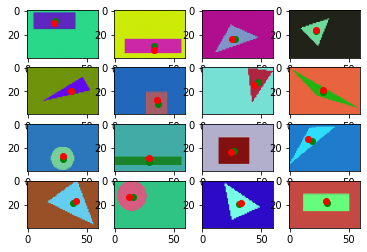

In [96]:
for i in range(16):

    img1 = x_test[i]
    img2 = img1.reshape(1,40,60,3)
    prediction = model.predict(img2)

    x = prediction[0][0]*60
    y = prediction[0][1]*40

    xy = y_test[i][0]*60
    yy = y_test[i][1]*40

    plt.subplot(4, 4, i+1)
    plt.plot(xy,yy, marker="o", color="green")
    plt.plot(x,y, marker="o", color="red")
    plt.imshow(img1, cmap="gray")

# LionNet Architecture

The leftmost path (-> Maxpool 3x3 -> Conv 1x1x32 ->) pools blocks of 3x3 pixels to be the largest of the values found in that block and then performs a 1x1 convolution with 32 output filters. This path will determine generalized features from the image since the image is essentially being down sized in resolution. The second path from the left (-> Conv 1x1x16 -> Conv 1x1x32 ->) extracts a set of features from the input (16 output filters) then refines these features by breaking them into more output filters (32). The middle path (-> Conv 1x1x64 ->) is simply attempting to extract 64 features that will not be refined in any way. The second from the right path (-> Conv 1x1x10 -> Conv 3x3x16 -> Conv 3x3x24 ->) determines 10 features from the input, then enlarges the receptive field by using a larger kernel size and attempts to find new features from this larger receptive field (10->16 output filters), this output is then refined with another 3x3 kernel and is broken down into more output filters when being refined. The rightmost path (-> Conv 1x1x10 -> Conv 5x5x32 ->) is simply extracting features and then attempting to generalize them very broadly with a large receptive field and more output filters for the new information retrieved from this operation.